<a href="https://colab.research.google.com/github/TheRufael/CS770-Assignments/blob/main/Assignment_three_Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Table of contents and setup
# Table of contents
# 1) Reproducibility and environment setup
# 2) Data load, preprocessing to RGB, resizing to 224x224, and tf.data pipelines
# 3) Transfer learning model builder and training utilities
# 4) Training: stage 1 (frozen base) and stage 2 (fine-tuning), then evaluation
# 5) Results table, learning curves, and confusion matrix

In [ ]:

# 1) Reproducibility and environment setup
SEED = 42

import os, time, random
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, utils

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Fix randomness
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

# Enable memory growth on GPU
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

print("TensorFlow", tf.__version__)
try:
    import sklearn
    print("Scikit-learn", sklearn.__version__)
except Exception:
    pass
print("Pandas", pd.__version__)
print("GPU devices", tf.config.list_physical_devices("GPU"))

TensorFlow 2.19.0
Scikit-learn 1.6.1
Pandas 2.2.2
GPU devices [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Data load, preprocessing to RGB, resizing to 224x224, and tf.data pipelines

# Load Fashion-MNIST
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] to satisfy the assignment rule
x_train_full = (x_train_full.astype("float32") / 255.0)[..., None]  # shape (60000, 28, 28, 1)
x_test       = (x_test.astype("float32") / 255.0)[..., None]        # shape (10000, 28, 28, 1)

# One-hot labels
NUM_CLASSES = 10
y_train_full_oh = utils.to_categorical(y_train_full, NUM_CLASSES)
y_test_oh       = utils.to_categorical(y_test, NUM_CLASSES)

# Fixed 80/20 split with stratification
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full_oh, test_size=0.20, random_state=SEED, stratify=y_train_full
)

# Choose a base architecture
# Supported: "MobileNetV2", "ResNet50", "VGG16", "InceptionV3"
ARCH = "MobileNetV2"

# Set input sizes
INPUT_SIZE_MAP = {
    "MobileNetV2": (224, 224),
    "ResNet50":    (224, 224),
    "VGG16":       (224, 224),
    "InceptionV3": (299, 299),
}
TARGET_H, TARGET_W = INPUT_SIZE_MAP[ARCH]
TARGET_SHAPE = (TARGET_H, TARGET_W, 3)

# Choose preprocess_input according to the selected architecture
from tensorflow.keras.applications import (
    mobilenet_v2, resnet50, vgg16, inception_v3
)

if ARCH == "MobileNetV2":
    preprocess_input = mobilenet_v2.preprocess_input
elif ARCH == "ResNet50":
    preprocess_input = resnet50.preprocess_input
elif ARCH == "VGG16":
    preprocess_input = vgg16.preprocess_input
elif ARCH == "InceptionV3":
    preprocess_input = inception_v3.preprocess_input
else:
    preprocess_input = mobilenet_v2.preprocess_input

# Build the tf.data pipelines
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Map function to convert grayscale to RGB, resize, and apply model-specific preprocessing
def to_rgb_resize_and_preprocess(x, y):
    # x is in [0,1] with shape (28,28,1)
    x_rgb = tf.image.grayscale_to_rgb(x)  # (28,28,3)
    x_resized = tf.image.resize(x_rgb, (TARGET_H, TARGET_W), method="bilinear")
    x_255 = x_resized * 255.0
    x_pp = preprocess_input(x_255)
    return x_pp, y

# Optional light augmentation for fine-tuning stability
def augment(x, y):
    x = tf.image.random_flip_left_right(x, seed=SEED)
    x = tf.image.random_brightness(x, max_delta=0.05)
    return x, y

train_ds = (tf.data.Dataset
            .from_tensor_slices((x_train, y_train))
            .shuffle(60000, seed=SEED, reshuffle_each_iteration=True)
            .map(to_rgb_resize_and_preprocess, num_parallel_calls=AUTOTUNE)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset
          .from_tensor_slices((x_val, y_val))
          .map(to_rgb_resize_and_preprocess, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .cache()
          .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset
           .from_tensor_slices((x_test, y_test_oh))
           .map(to_rgb_resize_and_preprocess, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))

print("Train", x_train.shape, "Val", x_val.shape, "Test", x_test.shape, "Target shape", TARGET_SHAPE)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train (48000, 28, 28, 1) Val (12000, 28, 28, 1) Test (10000, 28, 28, 1) Target shape (224, 224, 3)


In [ ]:
# Transfer learning model builder and training utilities

# Build a transfer model with a frozen base and a custom classifier head
def build_transfer_model(arch: str, input_shape: tuple, num_classes: int, dropout_rate=0.2):
    if arch == "MobileNetV2":
        base = mobilenet_v2.MobileNetV2(
            input_shape=input_shape, include_top=False, weights="imagenet")
        base_trainable_layers_default = 40  # used later for fine-tuning
        l2_reg = 1e-4
    elif arch == "ResNet50":
        base = resnet50.ResNet50(
            input_shape=input_shape, include_top=False, weights="imagenet")
        base_trainable_layers_default = 50
        l2_reg = 1e-4
    elif arch == "VGG16":
        base = vgg16.VGG16(
            input_shape=input_shape, include_top=False, weights="imagenet")
        base_trainable_layers_default = 4
        l2_reg = 5e-4
    elif arch == "InceptionV3":
        base = inception_v3.InceptionV3(
            input_shape=input_shape, include_top=False, weights="imagenet")
        base_trainable_layers_default = 50
        l2_reg = 1e-4
    else:
        base = mobilenet_v2.MobileNetV2(
            input_shape=input_shape, include_top=False, weights="imagenet")
        base_trainable_layers_default = 40
        l2_reg = 1e-4

    base.trainable = False  # freeze the convolutional base

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(dropout_rate, name="drop")(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2_reg),
                     name="dense_256")(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32", name="head")(x)
    model = models.Model(inputs, outputs, name=f"TL_{arch}")
    return model, base, base_trainable_layers_default

# Compile helper
def compile_model(model, lr=1e-3):
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Train helper with timing
def train_one(model, train_ds, val_ds, epochs, verbose=2, ckpt_path=None):
    cb = []
    if ckpt_path:
        cb.append(callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy",
                                            save_best_only=True, save_weights_only=True))
    cb.append(callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True))
    start = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose, callbacks=cb)
    secs = int(time.time() - start)
    return hist, secs

# Evaluation helper
def evaluate_acc(model, ds):
    _, acc = model.evaluate(ds, verbose=0)
    return float(acc)

# Plot curves
def plot_curves(hist_a, title_prefix):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(hist_a.history["accuracy"], label="Train")
    ax[0].plot(hist_a.history["val_accuracy"], label="Val")
    ax[0].set_title(f"{title_prefix} accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Accuracy"); ax[0].legend()
    ax[1].plot(hist_a.history["loss"], label="Train")
    ax[1].plot(hist_a.history["val_loss"], label="Val")
    ax[1].set_title(f"{title_prefix} loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss"); ax[1].legend()
    plt.tight_layout(); plt.show()

# Confusion matrix helper
CLASS_NAMES = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

def plot_confusion(model, ds, y_true_oh, title):
    y_true = np.argmax(y_true_oh, axis=1)
    y_pred = np.argmax(model.predict(ds, verbose=0), axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d",
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()
    return cm

In [ ]:
# Training: stage 1 (frozen base) and stage 2 (fine-tuning), then evaluation

# Build model
model, base, default_ft_layers = build_transfer_model(ARCH, (TARGET_H, TARGET_W, 3), NUM_CLASSES, dropout_rate=0.3)

# Stage 1: freeze base and train the new head
compile_model(model, lr=1e-3)
print(model.summary())
hist_stage1, secs_stage1 = train_one(model, train_ds, val_ds, epochs=10, verbose=2, ckpt_path="/tmp/tl_stage1.weights.h5")
val_acc_stage1 = evaluate_acc(model, val_ds)
test_acc_stage1 = evaluate_acc(model, test_ds)

# Stage 2: unfreeze the top portion of the base and fine-tune with a low learning rate
# You can change how many layers to unfreeze by setting UNFREEZE_FROM
if ARCH in ["MobileNetV2", "ResNet50", "InceptionV3"]:
    UNFREEZE_FROM = len(base.layers) - default_ft_layers
else:
    UNFREEZE_FROM = len(base.layers) - default_ft_layers

base.trainable = True
for i, layer in enumerate(base.layers):
    layer.trainable = (i >= UNFREEZE_FROM)

compile_model(model, lr=1e-4)
hist_stage2, secs_stage2 = train_one(model, train_ds, val_ds, epochs=15, verbose=2, ckpt_path="/tmp/tl_stage2.weights.h5")
val_acc_stage2 = evaluate_acc(model, val_ds)
test_acc_stage2 = evaluate_acc(model, test_ds)

# Keep artifacts for the report
artifacts = {
    "arch": ARCH,
    "stage1": {"hist": hist_stage1, "secs": secs_stage1, "val_acc": val_acc_stage1, "test_acc": test_acc_stage1},
    "stage2": {"hist": hist_stage2, "secs": secs_stage2, "val_acc": val_acc_stage2, "test_acc": test_acc_stage2},
    "model": model,
}

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "TL_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop (Dropout)                  │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/10
1500/1500 - 81s - 54ms/step - accuracy: 0.8407 - loss: 0.4841 - val_accuracy: 0.8758 - val_loss: 0.3791
Epoch 2/10
1500/1500 - 48s - 32ms/step - accuracy: 0.8689 - loss: 0.3969 - val_accuracy: 0.8902 - val_loss: 0.3464
Epoch 3/10
1500/1500 - 48s - 32ms/step - accuracy: 0.8803 - loss: 0.3730 - val_accuracy: 0.8997 - val_loss: 0.3308
Epoch 4/10
1500/1500 - 47s - 32ms/step - accuracy: 0.8845 - loss: 0.3654 - val_accuracy: 0.8953 - val_loss: 0.3398
Epoch 5/10
1500/1500 - 48s - 32ms/step - accuracy: 0.8887 - loss: 0.3566 - val_accuracy: 0.8956 - val_loss: 0.3467
Epoch 6/10
1500/1500 - 48s - 32ms/step - accuracy: 0.8916 - loss: 0.3515 - val_accuracy: 0.8983 - val_loss: 0.3403
Epoch 7/10
1500/1500 - 48s - 32ms/step - accuracy: 0.8958 - loss: 0.3400 - val_accuracy: 0.8969 - val_loss: 0.3400
Epoch 8/10
1500/1500 - 48s - 32ms/step - accuracy: 0.8971 - loss: 0.3404 - val_accuracy: 0.8950 - val_loss: 0.3490
Epoch 1/15
1500/1500 - 87s - 58ms/step - accuracy: 0.8952 - loss: 0.3409 - 

,Stage,Val Acc,Test Acc,Train Time (sec),Params
0,Frozen base,0.8997,0.8949,416,2588490
1,Fine-tuned,0.9367,0.9296,1079,2588490


Stage 1 learning curves


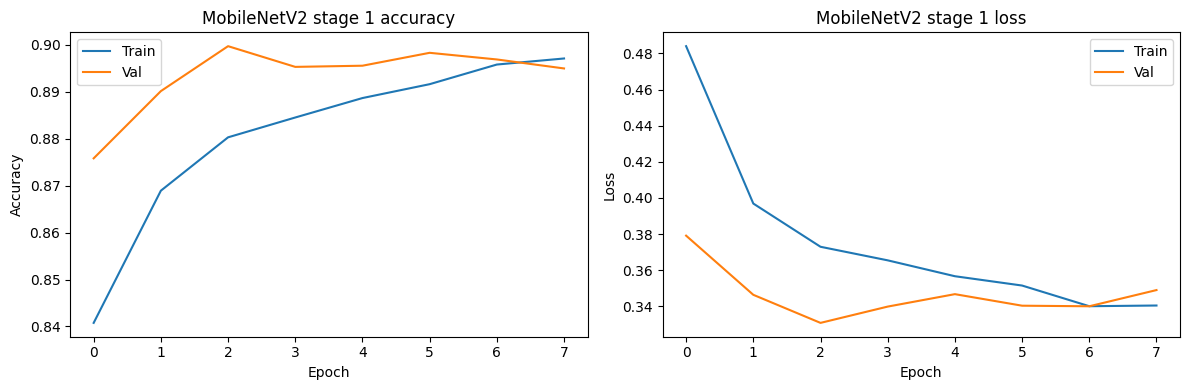

Stage 2 learning curves


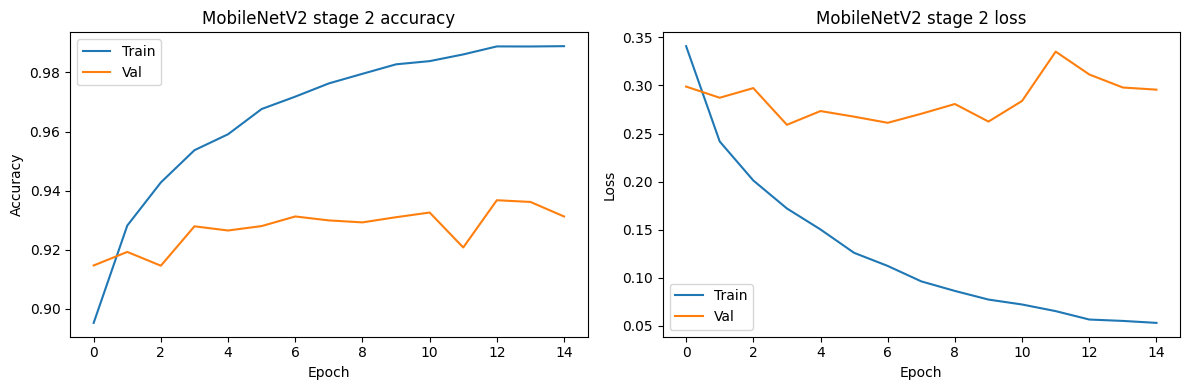

Confusion matrix on test set after fine-tuning


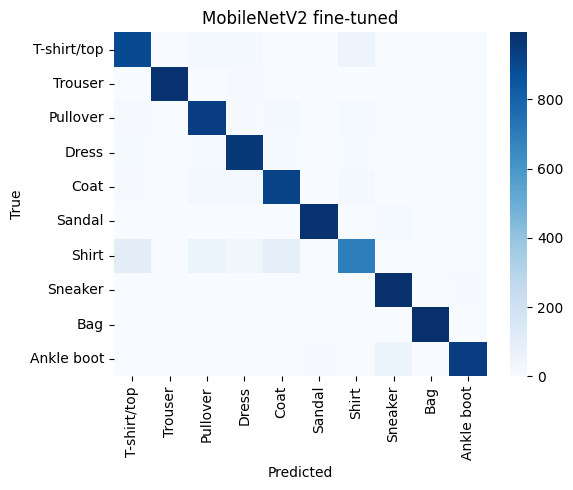

{'seed': 42, 'batch_size': 32, 'epochs_stage1': 10, 'epochs_stage2': 15}


In [ ]:
#  Results table, learning curves, and confusion matrix

# Results table
summary_df = pd.DataFrame([
    {"Stage":"Frozen base",   "Val Acc": artifacts["stage1"]["val_acc"], "Test Acc": artifacts["stage1"]["test_acc"],
     "Train Time (sec)": artifacts["stage1"]["secs"], "Params": artifacts["model"].count_params()},
    {"Stage":"Fine-tuned",    "Val Acc": artifacts["stage2"]["val_acc"], "Test Acc": artifacts["stage2"]["test_acc"],
     "Train Time (sec)": artifacts["stage2"]["secs"], "Params": artifacts["model"].count_params()},
])
try:
    display(summary_df.style.format({"Val Acc":"{:.4f}", "Test Acc":"{:.4f}"}))
except Exception:
    print(summary_df.to_string(index=False))

# Learning curves
print("Stage 1 learning curves")
plot_curves(artifacts["stage1"]["hist"], f"{artifacts['arch']} stage 1")
print("Stage 2 learning curves")
plot_curves(artifacts["stage2"]["hist"], f"{artifacts['arch']} stage 2")

# Confusion matrix on test set for the fine-tuned model
print("Confusion matrix on test set after fine-tuning")
cm_tuned = plot_confusion(artifacts["model"], test_ds, y_test_oh, f"{artifacts['arch']} fine-tuned")

# Reproducibility record
print({"seed": SEED, "batch_size": BATCH_SIZE, "epochs_stage1": 10, "epochs_stage2": 15})